<a href="https://colab.research.google.com/github/SaketMunda/introduction-to-nlp/blob/master/skimlit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Milestone Project : SkimLit 🗒 🔥

In this project, we're going to be putting what we've learned during the `introduction_to_nlp` notebook.

We're going to be replicating the deep learning model behind the 2017 paper [PubMed 200K RCT : a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

RCT : Randomized Controlled Trial abstracts

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

Input : an abstract of a RCT

Output : What role does each sentence serve in the abstract ?

**Problem**:

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution**:

Create an NLP model to classify abstract sentences into the role they play (e.g objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit) and dive deeper when necessary.

**Dataset**:

[PubMed RCT200k from Github](https://github.com/Franck-Dernoncourt/pubmed-rct)


**Replicating Model Architecture**:

[Neural Networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)



In [1]:
# check the gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-551bb471-41f6-316c-1579-dd7006421aaf)


In [2]:
# Import our Helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

from helper_functions import create_tensorboard_callback

--2023-03-15 02:17:52--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-03-15 02:17:53 (52.2 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Get the Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 13.34 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


So we have 4 major directories and each folder contain some txt files, let's check one of it,

In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


- `dev.txt` contains the abstracts for validation set
- `test.txt` is for testing
- `train.txt` is for the training the model

For the baseline and experiment purpose we can start with 20K data in which the numbers are replaces with @ sign, so basically we will use folder `PubMed_20k_RCT_numbers_replaced_with_at_sign`

In [5]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Because our data is in the text files/format, we need to preprocess it first to get ready for the model training and also to get familiar with we need to convert it to something that we will be easy for us to understand.

So let's write a function for it to read the text files,

In [6]:
def get_lines(filename):
  """
  Reads a filename(.txt) and returns the lines of text as a list
  """
  with open(filename,'r') as f:
    return f.readlines()    

In [7]:
# try with training samples
train_lines = get_lines(data_dir+'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

These are the lines of each individual abstracts (which are separated using the `###(_id)` at the start and `\n` in the end) and inside each abstract, there are multiple lines which have labels and texts which are separated with `\t`.

So we need to make this more readable for us and also for the machine. For this we can write a function which will gives us the list of dictionaries in the below format,

```
[{
  'line_number':0,
  'target':'OBJECTIVE',
  'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines':11,
}]
```


In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns the list of dictionaries of abstract line data.

  Takes the filename as input, reads its contents and sorts through each line,
  extracting things like the target label, text of the sentence, how many lines in
  that abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data={}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number 
        line_data['total_lines'] = len(abstract_lines_split) - 1 # total lines, starting from 0
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line
  
  return abstract_samples

In [9]:
# get data from files and preprocess it
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 354 ms, sys: 87.2 ms, total: 441 ms
Wall time: 441 ms


(180040, 30212, 30135)

Okay now we just created a list of dictionaries for each samples, let's see training samples how it looks

In [ ]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

For more visual understanding, let's use `pandas` Dataframe

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.shape

(180040, 4)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

In [ ]:
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our dataframe is ready, we can use data analysis functions of pandas,

In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

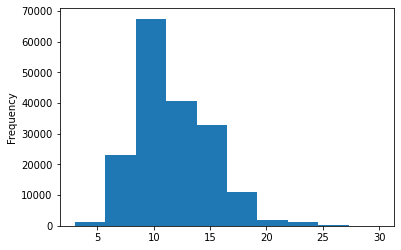

In [ ]:
# check the hist distribution of our abstract lenghts
train_df.total_lines.plot.hist();

Looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

### Get lists of sentences

We we build our deep learning models, one of its main inputs will be a list of string (the lines of an abstract).

In [11]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

# check first 10 sentences of training set
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

We're going to create label encoded and one hot encoded labels.

Tensorflow CategoriCalCrossEntropy loss function likes to have one hot encoded labels, so we also need one hot encoded labels but for baseline model like Scikit-Learn, label encoded is enough.

### One Hot Encoded

In [12]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In the above OneHotEncoder method passing `sparse=False` because if don't then tensorflow will throw an error while converting it into tensors.

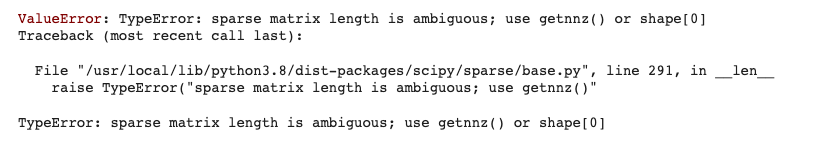

### Label Encoded


In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check the label encoded train labels
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

Let's get the classnames from the trained `LabelEncoder` using `classes_` attribute

In [14]:
# get the class names and number of classes from LabelENcoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

## Experiment with Various Models

Next we will be going to perform multiple experiments with various models starting from scikit-learn all the way to tensorflow transfer learning.

Modelling experiments will be,
- `model_0` : TFIDF Vectorizer and Multinomial Naive Bayes (baseline)
- `model_1` : Convolutional 1D with token embeddings
- `model_2` : TF Hub Pretrained Feature Extractor
- `model_3` : Conv1D with character embeddings
- `model_4` : Pretrained token embeddings (same as 2) + character embeddings (same as 3)
- `model_5` : Pretrained token embeddings + character embeddings + positional embeddings

### Evaluation Function 

Before starting with multiple modelling experiments we need to create a function for comparison with different metrics, so let's create it

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def calculate_results(model, tf_model=True, prefetching_used=False, val_dataset=None):
  '''
  Function returns the various metrics results by comparing the 
  y_true and y_pred of a model

  Args:
    - model : Trained model    
    - tf_model(bool) : If tensorflow model then True else False if Scikit-learn model
  
  Returns:
    Dictionary of metrics which are accuracy, precision, recall
    and f1-score    
  '''

  if tf_model:
    if prefetching_used:
      y_true = val_labels_encoded
      # make prediction
      y_pred = model.predict(val_dataset)
      y_pred = y_pred.argmax(axis=1)
    else:
      y_true = val_labels_one_hot.argmax(axis=1)
      # make prediction
      y_pred = model.predict(val_sentences)
      y_pred = y_pred.argmax(axis=1)
  else:
    y_true = val_labels_encoded # for sklearn 
    y_pred = model.predict(val_sentences)  
  

  # measure accuracy
  accuracy = accuracy_score(y_true, y_pred)
  # measure other metrics
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  return {"accuracy": accuracy*100,
          "f1":f1,
          "precision":precision,
          "recall":recall}

### Model_0 : Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# fit the training data to the model
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate the model using validation sentences
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# make some prediction
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# calculate results of baseline model
baseline_results = calculate_results(model_0, tf_model=False)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for Deep Learning Models

We need to create text vectorization and embedding layers for deep learning models.

The vectorization layer convert the text into numbers and embedding layer will capture the relationship betwen those numbers.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is 8 words long and another is 29 words long then we want to pad the 8 word sentences with zeros so it ends up being the same length as the 29 word sentence.

In [ ]:
# How long each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
average_len = np.mean(sent_lens)
average_len

26.338269273494777

How about the distribution of sentence lengths ?

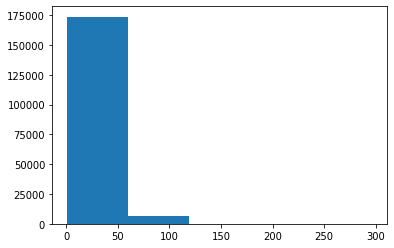

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=5);

Looks like majority of sentences are between 0 and 50 tokens in length.

We can use Numpy's `percentile` to find the value which covers 95% of the sentence lengths.

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Checking the maximum sentence length,

In [ ]:
max(sent_lens)

296

### Create Text Vectorizer

For converting text into numbers we'll use `TextVectorization` layer from tensorflow.

We'll keep the default parameters except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200K RCT Paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [ ]:
max_tokens = 68000

In [ ]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                           output_sequence_length=output_seq_len)

In [ ]:
# now need to adapt with training sample
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out the text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text:{len(target_sentence.split())}')
print(f'\nVectorized Text:\n{text_vectorizer([target_sentence])}')

Text:
overall pa ( counts per minute ) and its subcomponents , sedentary time and mvpa , were measured with accelerometry .

Length of text:21

Vectorized Text:
[[  188  1067  1414   160   929     3   308 34064  1751    63     3  4576
      9   156     7  9496     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Get more information from our `text_vectorizer` inside the `train_sentences`

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Numbers of vocabulary in train_sentences: {len(rct_20k_text_vocab)}")
print(f'Most common words in the vocabulary: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}')

Numbers of vocabulary in train_sentences: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# get the config of our text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create Custom Embedding

Now after creating the vectorization layer, we want to create embedding layer using Tensorflow's `Embedding` layer.

In [ ]:
# create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,
                               #mask_zero=True, # use masking to handle variable sequence length contains zeros
                               name="token_embedding")

# Show example embedding
print(f"Sentence before embedding:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n{vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before embedding:
overall pa ( counts per minute ) and its subcomponents , sedentary time and mvpa , were measured with accelerometry .
Sentence after vectorization:
[[  188  1067  1414   160   929     3   308 34064  1751    63     3  4576
      9   156     7  9496     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
[[[ 0.02003479  0.04521585  0.00980983 ...  0.011989    0.03733606
   -0.0443692 ]
  [-0.04421004  0.03939075 -0.04299101 ...  0.02285654 -0.0319016
    0.02766091]
  [-0.0264194  -0.01089637  0.02638673 ... -0.00123195 -0.00881873
    0.02294343]
  ...
  [-0.03542522 -0.01578521 -0.02050554 ...  0.02289356  0.03521183
    0.02927024]
  [-0.03542522 -0.01578521 -0.02050554 ...  0.02289356  0.03521183
    0.02927024]
  [-0.03542522 -0.01578521 -0.0205055

### Creating datasets (make sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed in the below guides,

- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/guide/data


In [ ]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSlicedDataset and turn them into prefetched batch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

So I guess now we are ready to build `model_1` i.e Conv1D with Token Embedding

## Model_1 : Conv1D with Token Embedding

In [ ]:
SAVE_DIR = 'model_logs'

### model without prefetching

In [ ]:
# create the model using Sequential API (without using prefetch)
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    token_embed,   
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(num_classes, activation='softmax')
], name='conv1d_with_token_embedding')

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(np.array(train_sentences),
                        train_labels_one_hot,
                        epochs=5,
                        validation_data=(np.array(val_sentences), val_labels_one_hot),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='conv1d_with_token_embeddings')])

Saving Tensorboard log files to: model_logs/conv1d_with_token_embeddings/20230314-032340
Epoch 1/5
5627/5627 [==============================] - 94s 15ms/step - loss: 0.5519 - accuracy: 0.7965 - val_loss: 0.4732 - val_accuracy: 0.8239
Epoch 2/5
5627/5627 [==============================] - 55s 10ms/step - loss: 0.3561 - accuracy: 0.8736 - val_loss: 0.5021 - val_accuracy: 0.8215
Epoch 3/5
5627/5627 [==============================] - 50s 9ms/step - loss: 0.2072 - accuracy: 0.9319 - val_loss: 0.5915 - val_accuracy: 0.8078
Epoch 4/5
5627/5627 [==============================] - 51s 9ms/step - loss: 0.1052 - accuracy: 0.9681 - val_loss: 0.7266 - val_accuracy: 0.7968
Epoch 5/5
5627/5627 [==============================] - 51s 9ms/step - loss: 0.0562 - accuracy: 0.9835 - val_loss: 0.8660 - val_accuracy: 0.7927


In [ ]:
model_1.summary()

Model: "conv1d_with_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,340,997
Trainable param

In [ ]:
# view results
model_1_results = calculate_results(model_1)
model_1_results

945/945 [==============================] - 4s 4ms/step


{'accuracy': 79.27313650205217,
 'f1': 0.7918375903355036,
 'precision': 0.7934848804813787,
 'recall': 0.7927313650205217}

### model with prefetching

In [ ]:
token_embed_1 = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

# creating model using Functional API
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed_1(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1_1 = tf.keras.Model(inputs, outputs, name='conv1D_with_token_embedding')


# compile the model
model_1_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# summary of the model
model_1_1.summary()

Model: "conv1D_with_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 5) 

In [ ]:
# fit the model
history_1_1 = model_1_1.fit(train_dataset,
                            steps_per_epoch=int(0.1 * len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1 * len(valid_dataset)),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1D_with_token_embeddings_prefetch")])

Saving Tensorboard log files to: model_logs/conv1D_with_token_embeddings_prefetch/20230314-032909
Epoch 1/3
562/562 [==============================] - 25s 42ms/step - loss: 0.9104 - accuracy: 0.6412 - val_loss: 0.6775 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6514 - accuracy: 0.7585 - val_loss: 0.6244 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6130 - accuracy: 0.7767 - val_loss: 0.5941 - val_accuracy: 0.7846


In [ ]:
# Make prediction
model_1_1_pred_probs = model_1_1.predict(valid_dataset)
model_1_1_preds = model_1_1_pred_probs.argmax(axis=1)
model_1_1_preds

945/945 [==============================] - 3s 3ms/step


array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# calculate results
model_1_1_results = calculate_results(model_1_1, prefetching_used=True, val_dataset=valid_dataset)
model_1_1_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 78.60452800211837,
 'f1': 0.7834676857355607,
 'precision': 0.7825881958246661,
 'recall': 0.7860452800211837}

## Model_2 : TensorFlow Hub Pretrained Feature Extractor

First, we would need a feature extractor embedding layer to transform text into numbers, so we are using Universal Sentence Encoder as a feature extraction embedding layer https://tfhub.dev/google/universal-sentence-encoder/4.

Then we can build the model and compile.

In [ ]:
import tensorflow_hub as hub

use_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name='use_embedding_layer')
random_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n{random_sentence}")
use_embedded = use_embedding_layer([random_sentence])
print(f"Sentence after Embedding:\n{use_embedded}")
print(f"Length of Embedding:\n{len(use_embedded[0])}")

Random Sentence:
both fortified-milk and - juice contained @iu of vitamin d and @mg of calcium per @ml package , whereas supplement contained @iu of vitamin d and @mg of calcium .
Sentence after Embedding:
[[-0.01992027  0.02218209  0.00043884 -0.00163391  0.01926553 -0.00595836
  -0.04564435 -0.00758143  0.03173718 -0.04005193  0.06768288 -0.04729965
  -0.06923101  0.06167563 -0.07010862 -0.01013438 -0.0701203   0.02620459
   0.06549206 -0.04049841  0.01331161 -0.01633611  0.01845932  0.00734234
   0.05115476 -0.04546858  0.05461957 -0.03067526 -0.01097544  0.05732596
  -0.03539908  0.07012136  0.06965438 -0.06897086 -0.06421398 -0.04832949
   0.02350096  0.01754689 -0.01124159 -0.05616271  0.04078012  0.06961457
  -0.05309973  0.00309905  0.06943762 -0.03957679 -0.02816619 -0.06188357
   0.01405423  0.04285766  0.00206493  0.02254457 -0.00734855 -0.01998623
   0.06881888 -0.00351026 -0.06302107  0.04875892  0.02898336 -0.02553841
   0.00760027 -0.05005938 -0.04376448 -0.03951588  0.0

Outputs of USE Embedding layer is 512 dimensional embedding vector.

### Building and Fitting an NLP Feature Extractor model using TensorFlow Hub

In [ ]:
# define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = use_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1 * len(valid_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "use_feature_extractor_model")])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Saving Tensorboard log files to: model_logs/use_feature_extractor_model/20230314-033049
Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9144 - accuracy: 0.6512 - val_loss: 0.7988 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7714 - accuracy: 0.6997 - val_loss: 0.7587 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7561 - accuracy: 0.7111 - val_loss: 0.7446 - val_accuracy: 0.7104


**Note:** Training is a lot quicker because we haven't set the parameter `trainable=True` while feature extraction.

In [ ]:
# see the summary
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 use_embedding_layer (KerasL  (None, 512)              256797824 
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7451 - accuracy: 0.7119


[0.7450690865516663, 0.711869478225708]

In [ ]:
# calculate results
model_2_results = calculate_results(model_2, prefetching_used=True, val_dataset=valid_dataset)
model_2_results

945/945 [==============================] - 14s 14ms/step


{'accuracy': 71.18694558453595,
 'f1': 0.7091327700709494,
 'precision': 0.7121877027024622,
 'recall': 0.7118694558453594}

## Model_3 : Conv1D with Character Embeddings

**What is Character Embedding ?**

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g `tensorflow` -> [`t`,`e`,`n`,`s`,`o`,`r`,`f`,`l`,`o`,`w`]) where as a **token embedding** is created on sequences split into tokens(words).

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding` layer.

### Create a Character Level Tokenizer

In [24]:
# we need to first split the sentences into chars
def split_chars(text):
  return " ".join(list(text))


# test splitting non-character level sequence into characters
#split_chars(random_sentence)

In [ ]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# now we need to find the maximum character length in each sentences
char_len = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_len)
mean_char_length

149.3662574983337

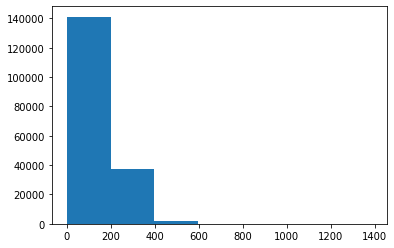

In [ ]:
# check the distribution
plt.hist(char_len, bins=7);

Looks like most of our sequences are between 0 and 200 characters long.

Let's use NumPy percentile to figure out what length covers 95% of our sequences.

In [ ]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

We can use `output_seq_char_len` for `output_sequence_length` in `TextVectorization` layer

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocab or unknown) tokens.

In [ ]:
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", # default setting
                                    name='char_vectorizer') 

# adapt the vectorizer
char_vectorizer.adapt(train_chars)

In [ ]:
# check the vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in the character vocab:{len(char_vocab)}')
print(f'5 Most common characters:{char_vocab[:5]}')
print(f'5 Least common characters:{char_vocab[-5:]}')

Number of different characters in the character vocab:28
5 Most common characters:['', '[UNK]', 'e', 't', 'i']
5 Least common characters:['k', 'x', 'z', 'q', 'j']


Test on random sentence

In [ ]:
random_train_chars = random.choice(train_chars)
print(f'Charified Text:\n {random_train_chars}')
print(f'\n Length of chars:{len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\n Vectorized Chars:\n{vectorized_chars}')
print(f'\n Length of vectorized chars:{len(vectorized_chars[0])}')

Charified Text:
 a l t h o u g h   t h i s   i s   a   n o v e l   o b s e r v a t i o n   f o r   r c c   ,   t h e s e   f i n d i n g s   r e q u i r e   v a l i d a t i o n   i n   p a t i e n t s   w i t h   m r c c   w h o   a r e   t r e a t e d   w i t h   o t h e r   t a r g e t e d   a g e n t s   .

 Length of chars:123

 Vectorized Chars:
[[ 5 12  3 13  7 16 18 13  3 13  4  9  4  9  5  6  7 21  2 12  7 22  9  2
   8 21  5  3  4  7  6 17  7  8  8 11 11  3 13  2  9  2 17  4  6 10  4  6
  18  9  8  2 26 16  4  8  2 21  5 12  4 10  5  3  4  7  6  4  6 14  5  3
   4  2  6  3  9 20  4  3 13 15  8 11 11 20 13  7  5  8  2  3  8  2  5  3
   2 10 20  4  3 13  7  3 13  2  8  3  5  8 18  2  3  2 10  5 18  2  6  3
   9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Create character-level embedding

Just like character-level tokenizer, we can create character-level embedding using `tensorflow.keras.layers.Embedding` and setting `input_dim` as the length of different character length i.e `char_vocab` and `output_dim` as 25, mentioned in the paper (Fig 1 https://arxiv.org/pdf/1612.05251.pdf)

In [ ]:
# create char level embedding
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero = False, # this time setting as False
                              name='char_embedding')

# test our embedding
print(f'Charified Text (before vectorization and embedding):\n{random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded Chars:\n{char_embed_example}')
print(f'Character Embedding Shape:{char_embed_example.shape}')

Charified Text (before vectorization and embedding):
a l t h o u g h   t h i s   i s   a   n o v e l   o b s e r v a t i o n   f o r   r c c   ,   t h e s e   f i n d i n g s   r e q u i r e   v a l i d a t i o n   i n   p a t i e n t s   w i t h   m r c c   w h o   a r e   t r e a t e d   w i t h   o t h e r   t a r g e t e d   a g e n t s   .
Embedded Chars:
[[[-0.04343532  0.04754268  0.02574823 ... -0.04403349 -0.01620372
    0.00551412]
  [ 0.0296496  -0.02018762 -0.02581667 ...  0.01099966  0.00945532
    0.02471733]
  [-0.02830079  0.04579849  0.03751646 ...  0.02230087  0.04303843
   -0.02448112]
  ...
  [ 0.03799814  0.00045107 -0.02319617 ... -0.00092135 -0.00687873
   -0.01242889]
  [ 0.03799814  0.00045107 -0.02319617 ... -0.00092135 -0.00687873
   -0.01242889]
  [ 0.03799814  0.00045107 -0.02319617 ... -0.00092135 -0.00687873
   -0.01242889]]]
Character Embedding Shape:(1, 290, 25)


### Create Char Level datasets

Same like train_dataset which is created using train_sentences we need to create prefetch dataset for character level data

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building, fitting and evaluating a Conv1D model on character embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_with_character_embeddings')

# compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# fit the model
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1 * len(val_char_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "conv1D_with_character_embeddings")])

Saving Tensorboard log files to: model_logs/conv1D_with_character_embeddings/20230314-033225
Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2638 - accuracy: 0.4946 - val_loss: 1.0494 - val_accuracy: 0.5785
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0074 - accuracy: 0.5991 - val_loss: 0.9351 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9278 - accuracy: 0.6341 - val_loss: 0.8630 - val_accuracy: 0.6722


In [ ]:
# evaluate
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8839 - accuracy: 0.6580


[0.8839402198791504, 0.6580497622489929]

In [ ]:
# calculate results
model_3_results = calculate_results(model=model_3,
                                    prefetching_used=True,
                                    val_dataset=val_char_dataset)

model_3_results

945/945 [==============================] - 3s 3ms/step


{'accuracy': 65.80497815437575,
 'f1': 0.6476547613072982,
 'precision': 0.6502856579303263,
 'recall': 0.6580497815437575}

## Model_4 : Pretrained Token Embeddings + Custom Character Embeddings (hybrid embedding layer)

In this modelling experiment, we are going to combine pretrained token embeddings and character embeddings into a hybrid embedding layer and concatenate the outputs of them using `layers.Concatenate`

To start replicating the model in Figure 1 of the paper, we're going to go through the following steps:

1. Create a token-level model (similar to `model_2`)
2. Create a character level model(similar to `model_3` with a slight modification to relect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to fig 1
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = use_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_tokenizer = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_tokenizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)


# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct a model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")


# compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])


# view the summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 use_embedding_layer (KerasLaye  (None, 512)         256797824   [

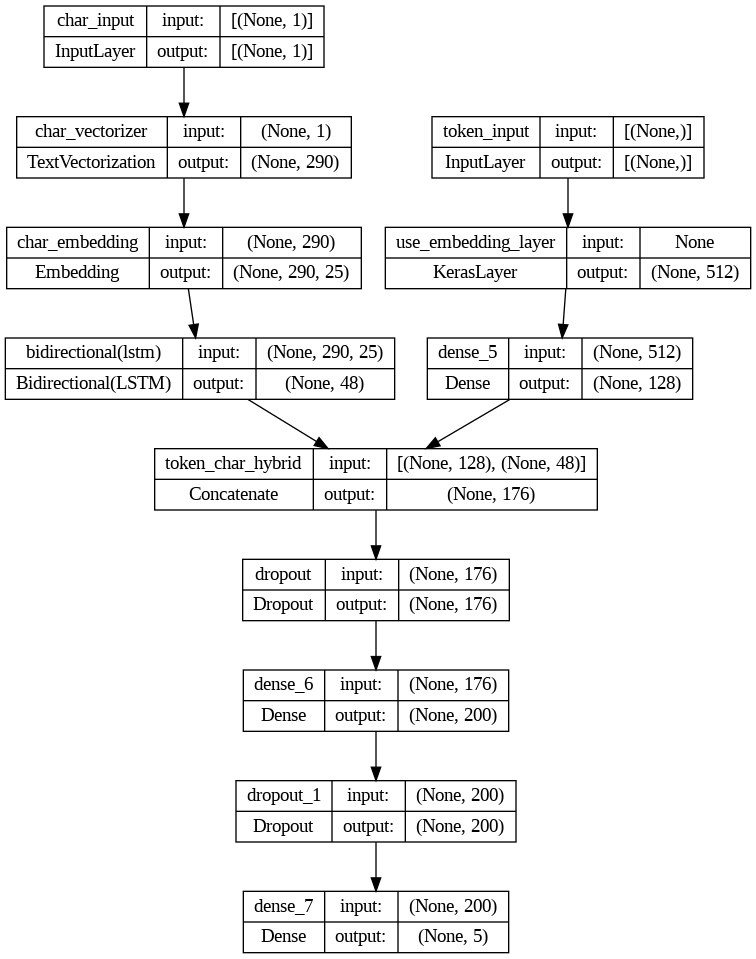

In [ ]:
# for more visual view of the model_4 architecture we can use keras utils
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Create Combined dataset of token and characters and prefetch them for model training

In [ ]:
# combine chars and tokens into a dataset
train_token_chars_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_chars_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_chars_dataset = tf.data.Dataset.zip((train_token_chars_data, train_token_chars_labels))

# prefetch and batch the data
train_token_chars_dataset = train_token_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_token_chars_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# same with validation set
val_token_chars_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_chars_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_chars_dataset = tf.data.Dataset.zip((val_token_chars_data, val_token_chars_labels))


val_token_chars_dataset = val_token_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_chars_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_4 = model_4.fit(train_token_chars_dataset,
                        steps_per_epoch=int(0.1 * len(train_token_chars_dataset)),
                        epochs=3,
                        validation_data=val_token_chars_dataset,
                        validation_steps=int(0.1 * len(val_token_chars_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_token_char_embeddings")])

Saving Tensorboard log files to: model_logs/model_4_token_char_embeddings/20230314-033250
Epoch 1/3
562/562 [==============================] - 28s 38ms/step - loss: 0.9692 - accuracy: 0.6124 - val_loss: 0.7816 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 22s 40ms/step - loss: 0.7966 - accuracy: 0.6912 - val_loss: 0.7195 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7672 - accuracy: 0.7073 - val_loss: 0.6935 - val_accuracy: 0.7384


In [ ]:
# evaluate the model
model_4.evaluate(val_token_chars_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6959 - accuracy: 0.7349


[0.6959028840065002, 0.7349066734313965]

In [ ]:
model_4_results = calculate_results(model=model_4, prefetching_used=True, val_dataset=val_token_chars_dataset)
model_4_results

945/945 [==============================] - 19s 19ms/step


{'accuracy': 73.49066596054547,
 'f1': 0.7325834274544754,
 'precision': 0.735311607624099,
 'recall': 0.7349066596054548}

## Model_5 : Transfer Learning with pretrained token embeddings + Character Embeddings + Positional Embeddings


The process of applying our own knowledge or understanding of data to build feature as input to a model is called as **feature engineering.**

If we look an abstract, would you expect the sentences to appear in order ? or does it make sense if they were to appear sequentially ? For example, sequences labelled `CONCLUSIONS` at the beginning and sequences labelled `OBJECTIVE` at the end ?


Abstracts typically come in a sequential order, such as:
- `OBJECTIVE`...
- `METHODS`...
- `METHODS`...
- `METHODS`..
- `METHODS`..
- `RESULTS`...
- `CONCLUSION`...

Or

- `BACKGROUND`...
- `OBJECTIVE`...
- `METHODS`...
- `METHODS`...
- `METHODS`..
- `METHODS`..
- `RESULTS`...
- `CONCLUSION`...

Of course we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

for example,

- `Sentence 1 of 10`...
- `Sentence 2 of 10`...
- `Sentence 3 of 10`...
- `Sentence 4 of 10`...
- ....


This type of information we already have through the function `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

In [ ]:
# inspecting training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `line_number` and `total_lines` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time.

### Create positional embeddings

Since our `line_number` and `total_lines` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `line_number=5` if five times greater than a line with `line_number=1`, we'll use one-hot-encoding to encode our `line_number` and `total_lines` features.

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

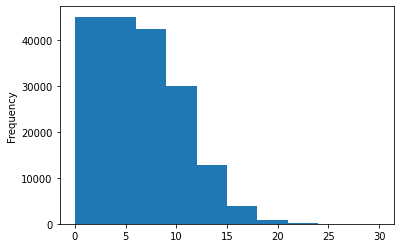

In [ ]:
# check the distribution
train_df.line_number.plot.hist();

It says the majority distribution area is between 0 and 15 which can cover the most `line_number` in our training dataset. So 15 is our depth while one-hot encoding.

In [ ]:
# Use tensorflow to create one-hot encoded tensors
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Doing the same thing with total lines

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

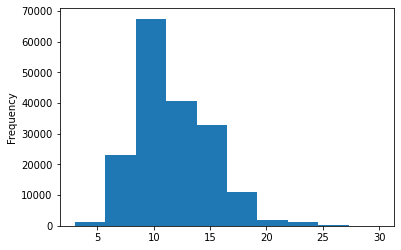

In [ ]:
train_df['total_lines'].plot.hist();

We can set a depth of 20 to cover majority of values of `total_lines`.

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

We're going to go through the following steps:
1. Create a token-level embedding model
2. Create a char-level embedding model
3. Create a `line_number` model
4. Create a `total_lines` model
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-char-hybrid embedding and pass it series of outputs.
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-char-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities.
8. Combine the inputs of 1,2,3,4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embed = use_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embed)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedded = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedded)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine outputs of 1 and 2
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embeddings')([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine outputs of 3,4,5
z = layers.Concatenate(name='token_char_position_embeddings')([line_number_model.output,
                                                                       total_lines_model.output,
                                                                       z])

# 7. Create an output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)

# 8. Put together Model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_model')

In [ ]:
model_5.summary()

Model: "model_5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 use_embedding_layer (KerasLaye  (None, 512)         256797824   ['token_input

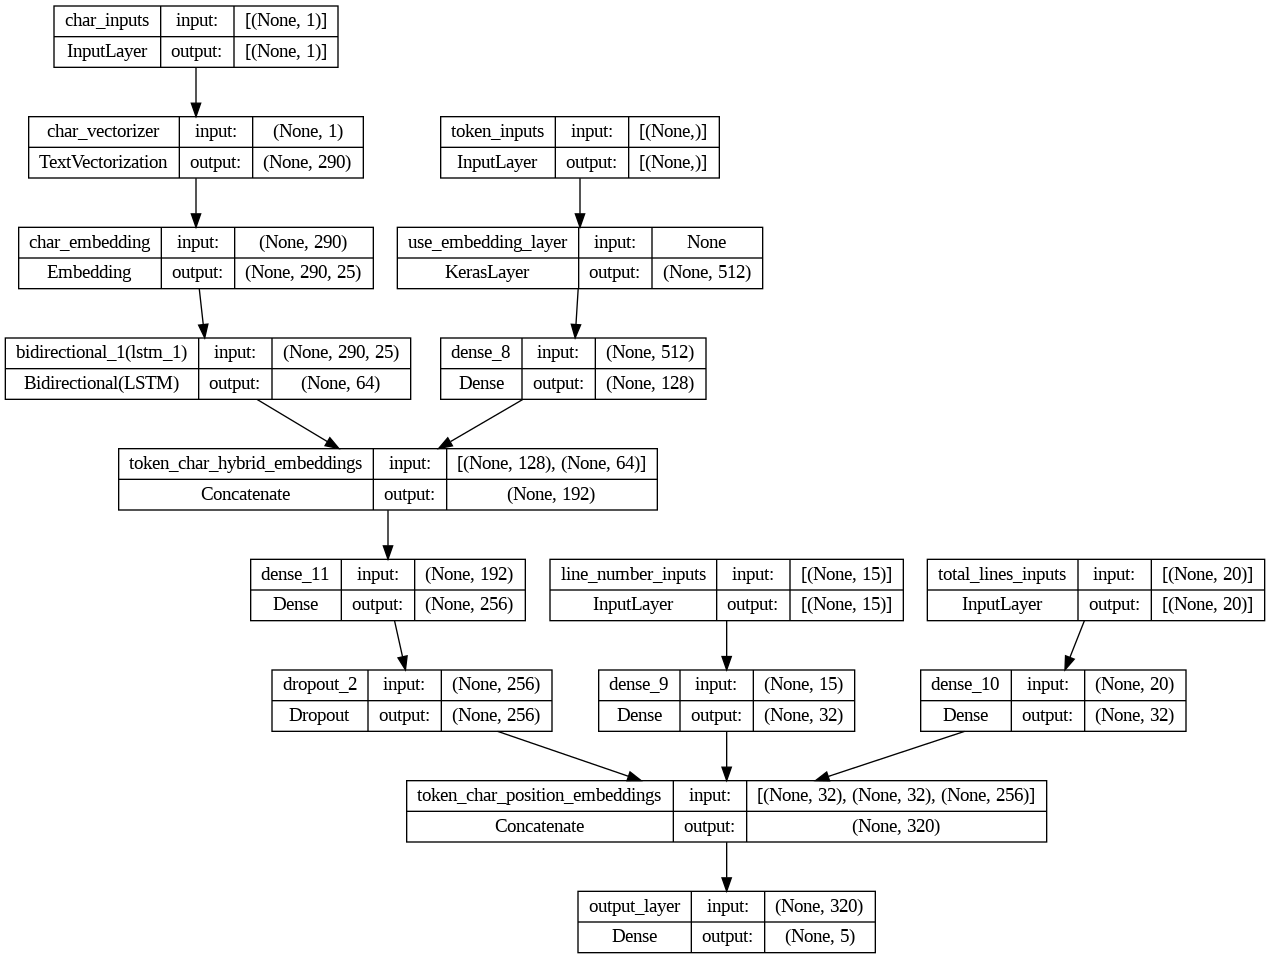

In [ ]:
# Plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# check how many layers of model is trainable
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fad61d17970> True
<keras.engine.input_layer.InputLayer object at 0x7fad61dd34c0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fad684769d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fad6828e370> False
<keras.layers.core.embedding.Embedding object at 0x7fad2ec0fb80> True
<keras.layers.core.dense.Dense object at 0x7fad61d177f0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fad61c85c10> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fad61ba5700> True
<keras.engine.input_layer.InputLayer object at 0x7fad61d37970> True
<keras.engine.input_layer.InputLayer object at 0x7fad61c36430> True
<keras.layers.core.dense.Dense object at 0x7fad61cc13d0> True
<keras.layers.core.dense.Dense object at 0x7fad61c836d0> True
<keras.layers.core.dense.Dense object at 0x7fad61cd0c40> True
<keras.layers.regularization.dropout.Dropout object at 0x7fad61c9f0d0> True
<keras.layers

This time while compiling the model we will use `label_smoothing` parameter in the loss function to prevent over-fitting the model.

Label smoothing helps to regularize our model by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:
- `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2)

It's predictions will get smoothed to be something like:
- `[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

> **Resources:** Blog post by PyImageSearch, [Label smoothing with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).



In [ ]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='Adam',
                metrics=['accuracy'])

For fitting the model we need to prepare the dataset and prefetch to optimize the training process.

### Create tribid embedding datasets and fit tribrid model

In [ ]:
# Training dataset
train_pos_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_pos_token_char_dataset = tf.data.Dataset.zip((train_pos_token_char_data, train_pos_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Validation
val_pos_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_pos_token_char_dataset = tf.data.Dataset.zip((val_pos_token_char_data, val_pos_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Testing
test_pos_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_token_char_dataset = tf.data.Dataset.zip((test_pos_token_char_data, test_pos_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# fit the model
history_5 = model_5.fit(train_pos_token_char_dataset,
                        epochs=5,
                        steps_per_epoch=int(0.1 * len(train_pos_token_char_dataset)),
                        validation_data=val_pos_token_char_dataset,
                        validation_steps=int(0.1 * len(val_pos_token_char_dataset)),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_tribrid_embeddings")])

Saving Tensorboard log files to: model_logs/model_5_tribrid_embeddings/20230314-033522
Epoch 1/5
562/562 [==============================] - 28s 39ms/step - loss: 1.0959 - accuracy: 0.7238 - val_loss: 0.9865 - val_accuracy: 0.8042
Epoch 2/5
562/562 [==============================] - 23s 40ms/step - loss: 0.9693 - accuracy: 0.8130 - val_loss: 0.9532 - val_accuracy: 0.8281
Epoch 3/5
562/562 [==============================] - 21s 38ms/step - loss: 0.9524 - accuracy: 0.8209 - val_loss: 0.9416 - val_accuracy: 0.8291
Epoch 4/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9414 - accuracy: 0.8321 - val_loss: 0.9292 - val_accuracy: 0.8348
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.9371 - accuracy: 0.8341 - val_loss: 0.9248 - val_accuracy: 0.8394


### Evaluation

In [ ]:
# evaluate the model
model_5.evaluate(val_pos_token_char_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.9233 - accuracy: 0.8417


[0.9232843518257141, 0.8417184948921204]

In [ ]:
# calculate the results
model_5_results = calculate_results(model=model_5,
                                    prefetching_used=True,
                                    val_dataset=val_pos_token_char_dataset)

model_5_results

945/945 [==============================] - 20s 20ms/step


{'accuracy': 84.1718522441414,
 'f1': 0.8376436768759833,
 'precision': 0.844755468013988,
 'recall': 0.841718522441414}

## Compare Results

Let's compare all the model results and plot them to experience it visually which model performed best and worse.

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1D": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_character_embed_conv1D": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed":model_5_results})

all_model_results = all_model_results.transpose()

all_model_results

,accuracy,f1,precision,recall
baseline,72.183238,0.698925,0.718647,0.721832
custom_token_embed_conv1D,79.273137,0.791838,0.793485,0.792731
pretrained_token_embed,71.186946,0.709133,0.712188,0.711869
custom_character_embed_conv1D,65.804978,0.647655,0.650286,0.658050
hybrid_char_token_embed,73.490666,0.732583,0.735312,0.734907
tribrid_pos_char_token_embed,84.171852,0.837644,0.844755,0.841719


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

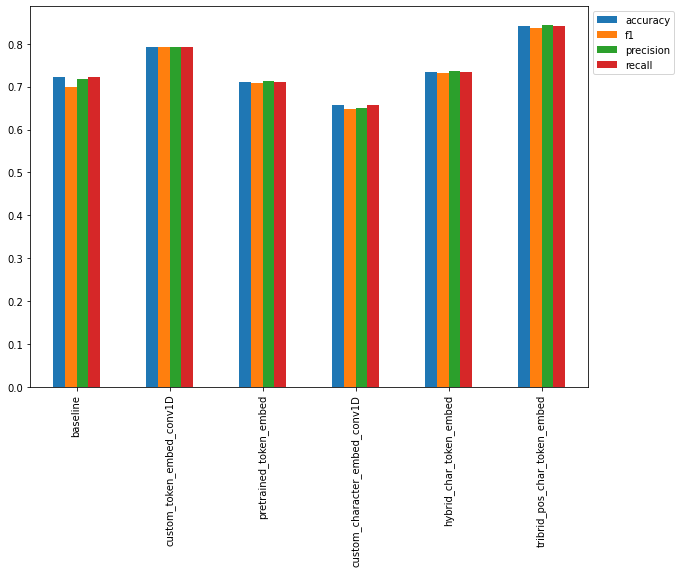

In [ ]:
# plot the results 
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Since in the paper [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071.pdf) their tested model's F1-scores on the test dataset, let's take at our model's F1-scores

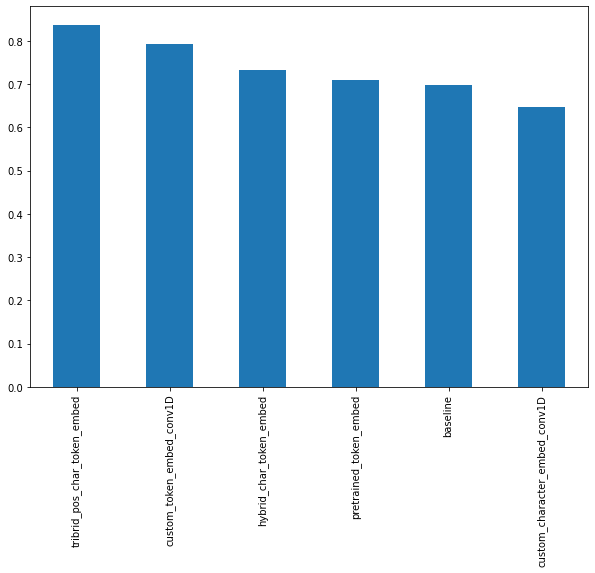

In [ ]:
all_model_results.sort_values(by="f1", ascending=False)["f1"].plot(kind='bar', figsize=(10,7));

## Save and Load best performing Model

In [ ]:
# save the model in SavedModel format
model_5.save('drive/MyDrive/Data Science/SkimLit/skimlit_tribrid_model')

In [15]:
# Load the model using tf.keras.models.load_model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization

model_path = "drive/MyDrive/Data Science/SkimLit/skimlit_tribrid_model"

loaded_model = tf.keras.models.load_model(model_path)

### Make predictions on Loaded Model and compare them with Trained model



In [ ]:
# prediction on loaded model
loaded_pred_probs = loaded_model.predict(val_pos_token_char_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 20s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# prediction on trained model
model_5_pred_probs = model_5.predict(val_pos_token_char_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

945/945 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# calculate the results of loaded model
loaded_model_results = calculate_results(model=loaded_model, prefetching_used=True, val_dataset=val_pos_token_char_dataset)

loaded_model_results

945/945 [==============================] - 18s 19ms/step


{'accuracy': 84.1718522441414,
 'f1': 0.8376436768759833,
 'precision': 0.844755468013988,
 'recall': 0.841718522441414}

In [ ]:
# compare the results with model_5
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()))

array([ True,  True,  True,  True])

In [ ]:
for layer in loaded_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fad15fdde80> True
<keras.engine.input_layer.InputLayer object at 0x7fad1c0b6760> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fad1c0b6b20> True
<keras.saving.legacy.saved_model.load.KerasLayer object at 0x7fad5e1edf70> False
<keras.layers.core.embedding.Embedding object at 0x7fad5e4683d0> True
<keras.layers.core.dense.Dense object at 0x7fad5e4686d0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fad2ee5b0d0> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fad1c259850> True
<keras.engine.input_layer.InputLayer object at 0x7fad1c29e6a0> True
<keras.engine.input_layer.InputLayer object at 0x7fad1c361970> True
<keras.layers.core.dense.Dense object at 0x7fad5ef26280> True
<keras.layers.core.dense.Dense object at 0x7fad1c3c7e20> True
<keras.layers.core.dense.Dense object at 0x7fad1c3c7190> True
<keras.layers.regularization.dropout.Dropout object at 0x7fad5eef0a00> True
<ke

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fad61d17970> True
<keras.engine.input_layer.InputLayer object at 0x7fad61dd34c0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fad684769d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fad6828e370> False
<keras.layers.core.embedding.Embedding object at 0x7fad2ec0fb80> True
<keras.layers.core.dense.Dense object at 0x7fad61d177f0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fad61c85c10> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fad61ba5700> True
<keras.engine.input_layer.InputLayer object at 0x7fad61d37970> True
<keras.engine.input_layer.InputLayer object at 0x7fad61c36430> True
<keras.layers.core.dense.Dense object at 0x7fad61cc13d0> True
<keras.layers.core.dense.Dense object at 0x7fad61c836d0> True
<keras.layers.core.dense.Dense object at 0x7fad61cd0c40> True
<keras.layers.regularization.dropout.Dropout object at 0x7fad61c9f0d0> True
<keras.layers

## Evaluate Model on Test dataset

We have already created the test dataset above as `test_pos_token_char_dataset`, let's use it for evaluating our best performing model.

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_token_char_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 18s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 2, 1, 4, 0])>

In [ ]:
# calculate the results
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# measure accuracy
accuracy = accuracy_score(test_labels_encoded, test_preds)
# measure other metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels_encoded, test_preds, average='weighted')

test_results = {"accuracy": accuracy*100,
                "f1":f1,
                "precision":precision,
                "recall":recall}

test_results

{'accuracy': 83.66351418616227,
 'f1': 0.8326381859625475,
 'precision': 0.8395261406971635,
 'recall': 0.8366351418616227}

It seems our best model performing(so far) still has some ways to go since in the paper that we are replicating the architecture of models is producing 90.0 F1-score on the test dataset, where as ours gets ~83 F1-score

However, as we discussed before our model has only been trained on 20K out of the total ~180K sequences in the RCT 20K dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find most wrong

One of the best ways to investigate where our model is going wrong (or potentially our data is wrong) is to visualize the "most wrong" predictions.

In [ ]:
pred_probs = tf.reduce_max(test_pred_probs, axis=1)
pred_probs

<tf.Tensor: shape=(30135,), dtype=float32, numpy=
array([0.4046165 , 0.4182503 , 0.8507006 , ..., 0.68377244, 0.6808784 ,
       0.4305441 ], dtype=float32)>

Let's update existing pandas dataframe and investigate which are the most wrong predictions

In [ ]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [ ]:
test_df['prediction'] = [label_encoder.classes_[pred] for pred in test_preds]
test_df['pred_probs'] = pred_probs
test_df['correct'] = test_df['prediction'] == test_df['target']

test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_probs,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.404617,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.418250,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.850701,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.812263,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.623403,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.791775,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.487537,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.480508,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.470356,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.603725,True


In [ ]:
wrong_prediction_df = test_df[test_df['correct']==False].sort_values(by='pred_probs', ascending=False)

wrong_prediction_df

,target,text,line_number,total_lines,prediction,pred_probs,correct
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.957610,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.950542,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.938968,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.933401,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.931609,False
...,...,...,...,...,...,...,...
5409,BACKGROUND,the aim of this randomised controlled trial ( ...,5,12,METHODS,0.248077,False
26060,RESULTS,two babies entered the randomised trial ; @ re...,2,9,METHODS,0.244861,False
24722,RESULTS,"for a given symptom cluster , the majority of ...",3,9,BACKGROUND,0.243961,False
6117,BACKGROUND,we set out to determine the optimal intraopera...,7,16,METHODS,0.243442,False


In [ ]:
# view top 10
wrong_prediction_df.head(10)

,target,text,line_number,total_lines,prediction,pred_probs,correct
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.957610,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.950542,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.938968,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.933401,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.931609,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.920129,False
13490,RESULTS,data were analyzed at baseline and longitudina...,4,14,METHODS,0.919602,False
15697,RESULTS,family practices were randomly assigned to rec...,3,11,METHODS,0.919196,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.917213,False
23630,RESULTS,the primary outcome was to evaluate changes in...,6,14,METHODS,0.916262,False


What do you notice about the wrong predictions? Does the model make silly mistakes? Or are some of the labels incorrect/ambiguous (e.g a line in an abstract could potentially be labelled `OBJECTIVE` or `BACKGROUND` and make sense).

A next step here would be if there are a fair few samples with inconsistent labels, you could go through your training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.

## Make Example Prediction

So far we've tested our model and made prediction on PubMed20K RCT dataset but now let's try our best performing model on a random abtract which is not formatted from PubMed website.



In [16]:
# Download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json

with open('skimlit_example_abstracts.json','r') as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-03-15 02:20:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-03-15 02:20:59 (75.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [17]:
## see what our abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


First we need to turn the abstract into sentences, and for this we will be using [spaCy's](https://spacy.io/)(a very powerful NLP library) `sentencizer` class. Which is an easy to use sentence splitter based on spacy's English language model.

In [20]:
from spacy.lang.en import English
nlp = English() # Setup english sentence parser

#sentencizer = nlp.create_pipe('sentencizer') # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]['abstract'])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

Beautiful ! It looks like spaCy has split the sentences in the abstract correctly. However, it should be noted, there may be more complex abstracts which don't get split perfectly into separate sentences, in such cases we have to make custom splitting techniques would need to investigate.

Now let's create the list of dictionary of all the abstracts into sentences which have the details like `line_number`, `total_lines`, `text`.

In [21]:
# get the total number of lines
total_lines_in_sample = len(abstract_lines)

# go through each line in abstract and create a list of dictionaries containing features of each line
sample_lines = []
for i,line in enumerate(abstract_lines):
  sample_dict={}
  sample_dict['line_number'] = i
  sample_dict['text'] = str(line)
  sample_dict['total_lines'] = total_lines_in_sample-1
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

Now we can create one_hot encoded version of `line_number` and `total_lines` as we did while training the model using tensorflow

In [23]:
test_abstract_line_numbers = [line['line_number'] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) # 15 because we have to keep the shape same as during training

test_abstract_total_lines = [line['total_lines'] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

test_abstract_line_numbers_one_hot, test_abstract_total_lines_one_hot

(<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(8, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0.

Also for making the prediction we have to create a character level input for the sentences, which we can do using `split_chars()` function that we created earlier.

In [25]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

By now we are done with preprocessing the random data took from RCT abstract into all of the same features our model was trained on, we can pass these features to our model and make sequence label prediction.

In [26]:
%%time

test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

test_abstract_pred_probs

1/1 [==============================] - 8s 8s/step
CPU times: user 3.46 s, sys: 528 ms, total: 3.99 s
Wall time: 8 s


array([[0.3456846 , 0.09908222, 0.03764057, 0.46792185, 0.0496707 ],
       [0.06982283, 0.03243677, 0.764544  , 0.08148947, 0.05170694],
       [0.10238814, 0.04076983, 0.6751919 , 0.11469958, 0.06695051],
       [0.09722325, 0.1368386 , 0.5528428 , 0.06933847, 0.14375688],
       [0.04441477, 0.10362911, 0.50050443, 0.04389993, 0.3075518 ],
       [0.03594806, 0.10035743, 0.58598465, 0.04114232, 0.2365676 ],
       [0.02798825, 0.237341  , 0.11322337, 0.02331263, 0.59813476],
       [0.01431818, 0.15276372, 0.26591775, 0.02608281, 0.5409176 ]],
      dtype=float32)

In [27]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [28]:
# Turn prediction class integers into labels
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [29]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f'{test_abstract_pred_classes[i]}: {line}')

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
